# Comprendre la Self-Attention

La self-attention est le mécanisme fondamental qui a révolutionné le traitement du langage naturel avec l'architecture Transformer introduite dans "Attention Is All You Need" (Vaswani et al., 2017).

## Pourquoi l'attention est importante ?

Contrairement aux architectures récurrentes (RNN, LSTM), l'attention permet au modèle de considérer **simultanément** tous les mots d'une séquence, et d'établir des relations directes entre n'importe quels mots, quelle que soit leur distance dans la phrase.

L'idée fondamentale est simple mais puissante :
- Chaque mot "interroge" tous les autres mots pour savoir lesquels sont pertinents pour sa propre représentation
- Les poids d'attention déterminent l'importance relative de chaque mot pour le mot courant
- Cela permet de capturer des dépendances à longue distance de manière efficace

Dans ce notebook, nous allons déconstruire ce mécanisme pour le comprendre de l'intérieur.

In [9]:
# Imports et configuration
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from pathlib import Path
import os

from model import build_transformer, MultiHeadAttentionBlock
from config import get_config, get_weights_file_path
from tokenizers import Tokenizer
from dataset import BilingualDataset, causal_mask

# Configuration
config = get_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

Utilisation de: cuda


In [10]:
# Chargement des tokenizers et utilitaires
# Charger les tokenizers
tokenizer_src = Tokenizer.from_file(config["tokenizer_file"].format(config["lang_src"]))
tokenizer_target = Tokenizer.from_file(config["tokenizer_file"].format(config["lang_target"]))

def load_model(epoch):
    """Charge le modèle pour une époque donnée"""
    model_filename = get_weights_file_path(config, f"{epoch:02d}")
    
    model = build_transformer(
        tokenizer_src.get_vocab_size(),
        tokenizer_target.get_vocab_size(),
        config["seq_len"],
        config["seq_len"],
        config["d_model"]
    ).to(device)
    
    state_dict = torch.load(model_filename)
    model.load_state_dict(state_dict["model_state_dict"])
    model.eval()
    
    return model

def prepare_input(text, tokenizer_src):
    """Prépare une phrase pour le modèle"""
    # Tokenisation
    tokens = tokenizer_src.encode(text).ids
    
    # Ajout des tokens spéciaux
    sos_token = tokenizer_src.token_to_id('[SOS]')
    eos_token = tokenizer_src.token_to_id('[EOS]')
    pad_token = tokenizer_src.token_to_id('[PAD]')
    
    tokens = [sos_token] + tokens + [eos_token]
    num_padding = config["seq_len"] - len(tokens)
    
    if num_padding < 0:
        tokens = tokens[:config["seq_len"]-1] + [eos_token]
    else:
        tokens = tokens + [pad_token] * num_padding
    
    # Création des tenseurs
    encoder_mask = (torch.tensor(tokens) != pad_token).unsqueeze(0).unsqueeze(0).int().to(device)
    encoder_input = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    
    return encoder_input, encoder_mask, tokens

In [11]:
# Recherche des époques disponibles
available_epochs = []
for file in os.listdir(config["model_folder"]):
    if file.startswith(config["model_basename"]) and file.endswith(".pt"):
        epoch = file[len(config["model_basename"]):-3]
        if epoch.isdigit():
            available_epochs.append(int(epoch))

available_epochs.sort()
print(f"Époques disponibles: {available_epochs}")

# Phrase exemple
example_text = "I would like to learn more about artificial intelligence."
print(f"\nPhrase d'exemple: '{example_text}'")

Époques disponibles: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

Phrase d'exemple: 'I would like to learn more about artificial intelligence.'


In [12]:
# Fonction de traduction
def translate_text(text, epoch):
    """Traduit un texte avec le modèle d'une époque donnée"""
    model = load_model(epoch)
    encoder_input, encoder_mask, _ = prepare_input(text, tokenizer_src)
    
    # Génération de la traduction
    sos_token = tokenizer_target.token_to_id('[SOS]')
    eos_token = tokenizer_target.token_to_id('[EOS]')
    decoder_input = torch.tensor([[sos_token]]).to(device)
    
    encoder_output = model.encode(encoder_input, encoder_mask)
    output_tokens = []
    
    with torch.no_grad():
        for _ in range(config["seq_len"]):
            decoder_mask = causal_mask(decoder_input.size(1)).to(device)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            projection = model.project(decoder_output)
            next_token = projection[0, -1].argmax().item()
            
            if next_token == eos_token:
                break
                
            output_tokens.append(next_token)
            decoder_input = torch.cat([decoder_input, torch.tensor([[next_token]]).to(device)], dim=1)
    
    return tokenizer_target.decode(output_tokens)

## Query, Key, Value : les trois piliers de l'attention

La self-attention repose sur trois composants essentiels, tous dérivés de la même entrée mais servant des fonctions différentes :

### 1. Query (Q) - "Que cherche-t-on ?"
- Pour chaque position, la query représente "ce que cette position recherche"
- C'est comme une question posée par un mot pour savoir quels autres mots sont pertinents

### 2. Key (K) - "Que propose-t-on ?"
- Les keys sont "ce que chaque position offre" aux autres positions
- Elles permettent de déterminer la compatibilité avec les queries

### 3. Value (V) - "Quelle information transmet-on ?"
- Les values contiennent "l'information à extraire" de chaque position
- Elles sont pondérées par les scores d'attention pour former la sortie finale

Le mécanisme fonctionne comme suit :
1. On calcule la similarité entre chaque query et toutes les keys (`Q·K^T`)
2. On normalise ces scores via softmax pour obtenir des poids d'attention
3. On agrège les values en les pondérant par ces poids d'attention

Mathématiquement : `Attention(Q,K,V) = softmax(QK^T/√d_k)·V`

In [13]:
# Fonction de visualisation de l'attention
def visualize_attention(text, epoch):
    """Visualise les patterns d'attention pour une phrase et une époque données"""
    model = load_model(epoch)
    encoder_input, encoder_mask, tokens = prepare_input(text, tokenizer_src)
    token_texts = [tokenizer_src.id_to_token(t) for t in tokens if t != tokenizer_src.token_to_id('[PAD]')]
    
    with torch.no_grad():
        # Obtenir les embeddings
        embedded_input = model.src_embed(encoder_input)
        
        # Calculer l'attention
        encoder_block = model.encoder.layers[0]
        x_norm = encoder_block.residual_connections[0].norm(embedded_input)
        attention_block = encoder_block.self_attention_block
        
        # Q, K, V
        q = attention_block.w_q(x_norm)
        k = attention_block.w_k(x_norm)
        v = attention_block.w_v(x_norm)
        
        # Reshape pour multi-têtes
        batch_size = q.shape[0]
        q = q.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
        k = k.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
        v = v.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
        
        # Scores d'attention
        d_k = q.shape[-1]
        scores = (q @ k.transpose(-2, -1)) / np.sqrt(d_k)
        scores.masked_fill_(encoder_mask == 0, -1e9)
        attention_scores = torch.nn.functional.softmax(scores, dim=-1).cpu().numpy()[0]
        
    return attention_scores, token_texts

In [12]:
# Visualisation de l'évolution
print("Évolution des traductions:")
print("-" * 80)
for epoch in available_epochs:
    translation = translate_text(example_text, epoch)
    print(f"\nÉpoque {epoch}:")
    print(f"Source: {example_text}")
    print(f"Traduction: {translation}")
    print("-" * 40)

Évolution des traductions:
--------------------------------------------------------------------------------

Époque 0:
Source: I would like to learn more about artificial intelligence.
Traduction: Je me rappelle que je me à l ' air .
----------------------------------------

Époque 1:
Source: I would like to learn more about artificial intelligence.
Traduction: Je voudrais bien savoir plus de .
----------------------------------------

Époque 2:
Source: I would like to learn more about artificial intelligence.
Traduction: Je voudrais savoir plus de l ’ intelligence .
----------------------------------------

Époque 3:
Source: I would like to learn more about artificial intelligence.
Traduction: Je voudrais savoir plus de l ' esprit .
----------------------------------------

Époque 4:
Source: I would like to learn more about artificial intelligence.
Traduction: Je voudrais savoir plus d ’ esprit .
----------------------------------------

Époque 5:
Source: I would like to learn more ab

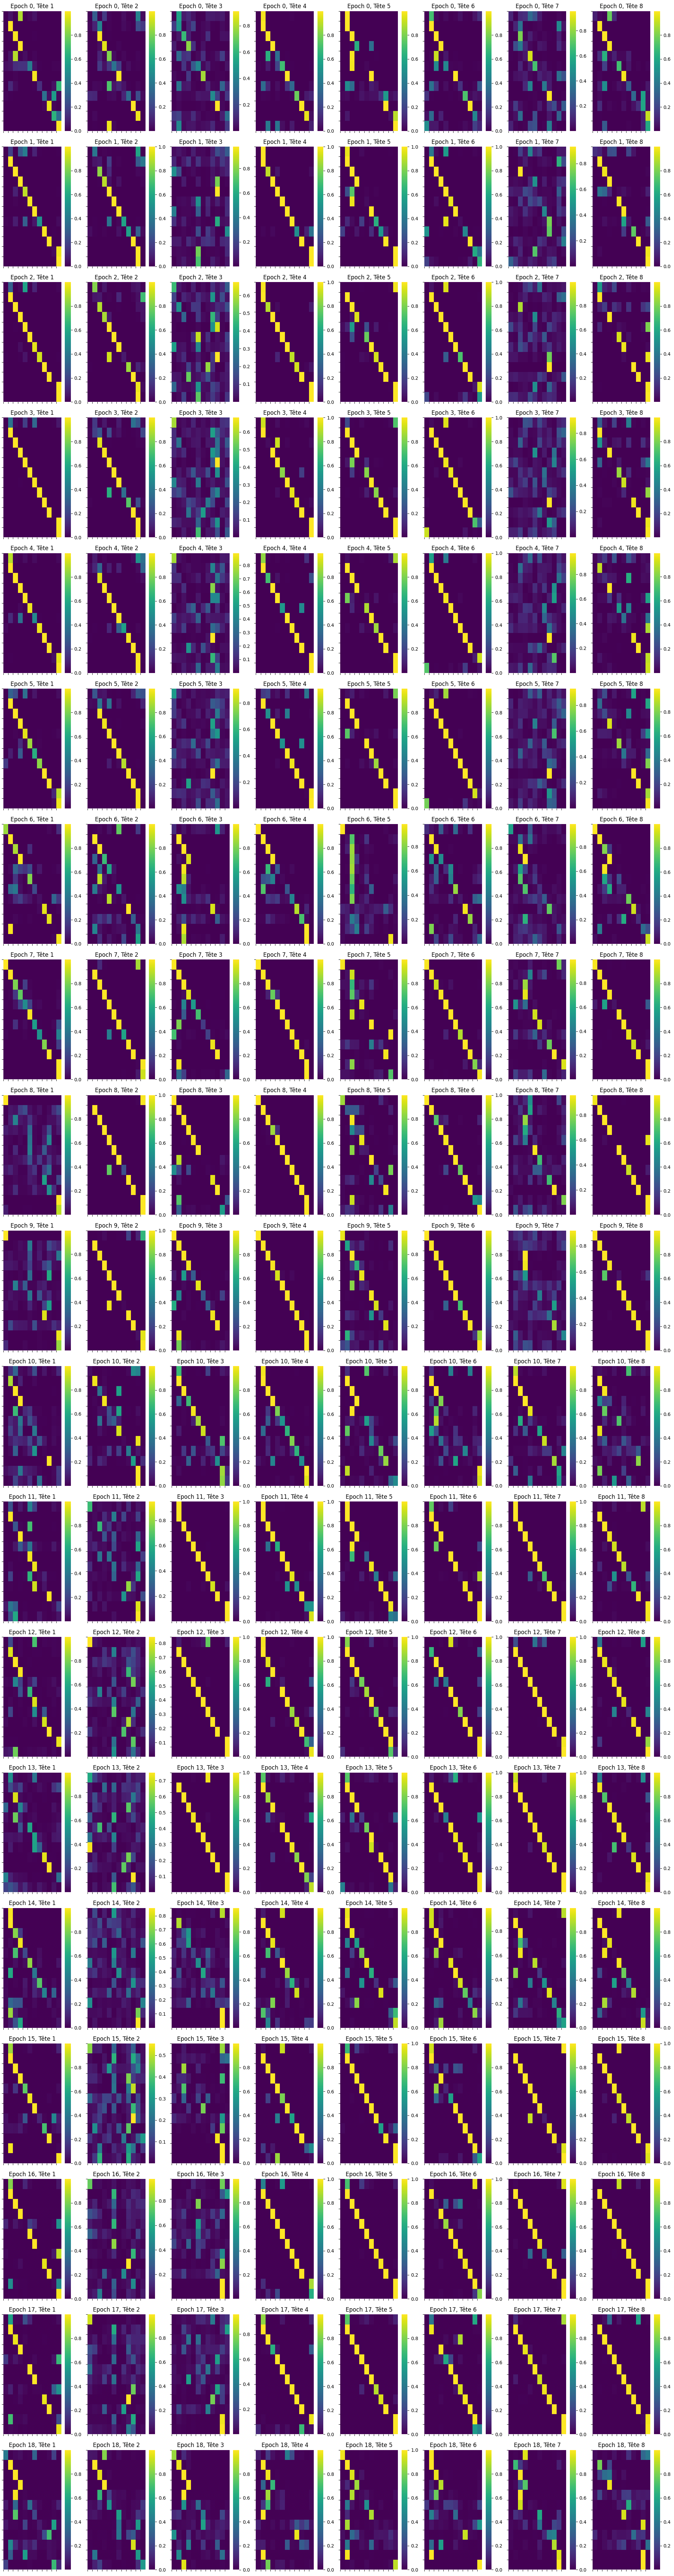

In [13]:
# Visualisation des patterns d'attention
n_epochs = len(available_epochs)
n_heads = config["d_model"] // 64  # Généralement 8 têtes pour d_model=512
fig, axes = plt.subplots(n_epochs, n_heads, figsize=(20, 4*n_epochs))

if n_epochs == 1:
    axes = [axes]

for i, epoch in enumerate(available_epochs):
    attention_scores, token_texts = visualize_attention(example_text, epoch)
    valid_len = len(token_texts)
    
    for h in range(n_heads):
        scores_to_plot = attention_scores[h, :valid_len, :valid_len]
        ax = axes[i][h]
        
        sns.heatmap(scores_to_plot, 
                    annot=False, 
                    cmap="viridis", 
                    xticklabels=token_texts, 
                    yticklabels=token_texts,
                    ax=ax)
        
        ax.set_title(f"Epoch {epoch}, Tête {h+1}")
        ax.set_xticklabels(token_texts, rotation=90)
        ax.set_yticklabels(token_texts, rotation=0)
        ax.set_xticks(np.arange(0, len(token_texts)))
        ax.set_yticks(np.arange(0, len(token_texts)))
        ax.grid(False)

plt.tight_layout()
plt.show()

In [6]:
test_sentences = [
    "I would like to learn more about artificial intelligence.",
    "The cat is sleeping on the mat.",
    "Although it was raining, he went for a walk.",
    "The keys to the cabinet are on the table.",
    "Could you please help me with my homework?"
]

# Afficher les traductions pour chaque époque
print("ÉVOLUTION DES TRADUCTIONS")
print("=" * 100)


for sentence in test_sentences:
    print(f"\nSOURCE: {sentence}")
    print("-" * 100)
    for epoch in available_epochs:
        print(f"\nÉPOQUE {epoch}")
        translation = translate_text(sentence, epoch)
        print(f"Traduction: {translation}")
        print("-" * 80)

ÉVOLUTION DES TRADUCTIONS

SOURCE: I would like to learn more about artificial intelligence.
----------------------------------------------------------------------------------------------------

ÉPOQUE 0
Traduction: Je me rappelle que je me à l ' air .
--------------------------------------------------------------------------------

ÉPOQUE 1
Traduction: Je voudrais bien savoir plus de .
--------------------------------------------------------------------------------

ÉPOQUE 2
Traduction: Je voudrais savoir plus de l ’ intelligence .
--------------------------------------------------------------------------------

ÉPOQUE 3
Traduction: Je voudrais savoir plus de l ' esprit .
--------------------------------------------------------------------------------

ÉPOQUE 4
Traduction: Je voudrais savoir plus d ’ esprit .
--------------------------------------------------------------------------------

ÉPOQUE 5
Traduction: Je voudrais bien apprendre plus d ’ esprit .
------------------------------

KeyboardInterrupt: 

In [14]:
def translate_with_selected_heads(text, epoch, selected_heads=[0, 1, 2, 3]):
    """Traduit un texte en n'utilisant que certaines têtes d'attention"""
    model = load_model(epoch)
    encoder_input, encoder_mask, _ = prepare_input(text, tokenizer_src)
    
    # Créer un masque pour les têtes d'attention
    head_mask = torch.zeros(model.encoder.layers[0].self_attention_block.h).to(device)
    head_mask[selected_heads] = 1.0  # Activer seulement les têtes sélectionnées
    
    # Modifier la fonction d'attention pour appliquer le masque
    def masked_attention(query, key, value, mask, dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
            
        # Appliquer le masque des têtes
        attention_scores = attention_scores * head_mask.view(1, -1, 1, 1)
        
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
            
        return (attention_scores @ value), attention_scores
    
    # Sauvegarder l'ancienne fonction d'attention
    old_attention = MultiHeadAttentionBlock.attention
    # Remplacer par notre version masquée
    MultiHeadAttentionBlock.attention = staticmethod(masked_attention)
    
    try:
        # Génération de la traduction
        sos_token = tokenizer_target.token_to_id('[SOS]')
        eos_token = tokenizer_target.token_to_id('[EOS]')
        decoder_input = torch.tensor([[sos_token]]).to(device)
        
        encoder_output = model.encode(encoder_input, encoder_mask)
        output_tokens = []
        
        with torch.no_grad():
            for _ in range(config["seq_len"]):
                decoder_mask = causal_mask(decoder_input.size(1)).to(device)
                decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
                projection = model.project(decoder_output)
                next_token = projection[0, -1].argmax().item()
                
                if next_token == eos_token:
                    break
                    
                output_tokens.append(next_token)
                decoder_input = torch.cat([decoder_input, torch.tensor([[next_token]]).to(device)], dim=1)
        
        translation = tokenizer_target.decode(output_tokens)
        
    finally:
        # Restaurer l'ancienne fonction d'attention
        MultiHeadAttentionBlock.attention = old_attention
    
    return translation

In [15]:
# Test avec différentes combinaisons de têtes
test_sentence = "I would like to learn more about artificial intelligence."
print("Phrase source:", test_sentence)
print("\nTraductions avec différentes têtes d'attention:")

head_combinations = [
    [0, 1, 2, 3, 5, 7], # Têtes pour l'époque 7 diagonales
    [4, 6], # Têtes pour l'époque 7 non diagonales
    list(range(3,8)), # Têtes pour l'époque 17 diagonale
    [0] + list(range(3,8)), # Test pour l'époque 17 diagonal permissif
    [1,2], # Test pour l'époque 17 pas de diagonale
    list(range(8)),   # Toutes les têtes (référence)
]

Phrase source: I would like to learn more about artificial intelligence.

Traductions avec différentes têtes d'attention:


In [8]:


for epoch in [7, 17, 18]:#available_epochs:
    print(f"\nÉPOQUE {epoch}\n")
    for heads in head_combinations:
        translation = translate_with_selected_heads(test_sentence, epoch, heads)
        print(f"\nTêtes utilisées {heads}:")
        print(f"Traduction: {translation}")
        print("-" * 80)
    print("\n" + "=" * 100 + "\n")

Phrase source: I would like to learn more about artificial intelligence.

Traductions avec différentes têtes d'attention:

ÉPOQUE 7


Têtes utilisées [0, 1, 2, 3, 5, 7]:
Traduction: J ' essayai de me faire des .
--------------------------------------------------------------------------------

Têtes utilisées [4, 6]:
Traduction: 
--------------------------------------------------------------------------------

Têtes utilisées [3, 4, 5, 6, 7]:
Traduction: J ' d ' une certaine intelligence .
--------------------------------------------------------------------------------

Têtes utilisées [0, 3, 4, 5, 6, 7]:
Traduction: J ’ aurais voulu me donner des .
--------------------------------------------------------------------------------

Têtes utilisées [1, 2]:
Traduction: 
--------------------------------------------------------------------------------

Têtes utilisées [0, 1, 2, 3, 4, 5, 6, 7]:
Traduction: Je voulus me demander plus de l ' esprit .
---------------------------------------------

In [20]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import sacrebleu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import itertools

# Télécharger les ressources NLTK nécessaires
nltk.download('punkt')

nltk.download('punkt_tab')

# Fonction pour calculer le score BLEU
def calculate_bleu(reference, hypothesis):
    """Calcule le score BLEU pour une traduction"""
    # Tokenisation
    ref_tokens = nltk.word_tokenize(reference.lower())
    hyp_tokens = nltk.word_tokenize(hypothesis.lower())
    
    # Application de la fonction de lissage pour gérer les phrases courtes
    smoothie = SmoothingFunction().method1
    
    # Calcul du score BLEU avec différentes n-grammes
    bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    
    return {
        'bleu1': bleu1,
        'bleu2': bleu2,
        'bleu3': bleu3,
        'bleu4': bleu4
    }

# Fonction pour calculer le score chrF (plus sensible aux variations grammaticales)
def calculate_chrf(reference, hypothesis):
    """Calcule le score chrF pour une traduction"""
    chrf = sacrebleu.corpus_chrf([hypothesis], [[reference]])
    return chrf.score

# Fonction pour calculer le TER (Translation Error Rate)
def calculate_ter(reference, hypothesis):
    """Calcule le taux d'erreur de traduction"""
    ter = sacrebleu.corpus_ter([hypothesis], [[reference]])
    return ter.score

[nltk_data] Downloading package punkt to /home/na2s/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/na2s/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# In[11]: Création d'un ensemble de test
# Nous allons créer un ensemble de phrases test représentatives
test_set = [
    {
        'src': "I would like to learn more about artificial intelligence.",
        'ref': "J'aimerais en apprendre davantage sur l'intelligence artificielle."
    },
    {
        'src': "The cat is sleeping on the mat.",
        'ref': "Le chat dort sur le tapis."
    },
    {
        'src': "Although it was raining, he went for a walk.",
        'ref': "Bien qu'il pleuvait, il est allé se promener."
    },
    {
        'src': "The keys to the cabinet are on the table.",
        'ref': "Les clés du placard sont sur la table."
    },
    {
        'src': "Could you please help me with my homework?",
        'ref': "Pourriez-vous m'aider avec mes devoirs s'il vous plaît?"
    },
    {
        'src': "She has been working on this project for three years.",
        'ref': "Elle travaille sur ce projet depuis trois ans."
    },
    {
        'src': "I don't understand why he refused our offer.",
        'ref': "Je ne comprends pas pourquoi il a refusé notre offre."
    },
    {
        'src': "The movie we watched last night was very interesting.",
        'ref': "Le film que nous avons regardé hier soir était très intéressant."
    },
    {
        'src': "The new restaurant in town serves delicious food.",
        'ref': "Le nouveau restaurant en ville sert une nourriture délicieuse."
    },
    {
        'src': "Scientists have discovered a new species of butterfly.",
        'ref': "Les scientifiques ont découvert une nouvelle espèce de papillon."
    }
]

In [3]:
# In[12]: Évaluation des performances par époque
def evaluate_epochs(test_set, epochs=None):
    """Évalue les performances de traduction à différentes époques"""
    if epochs is None:
        epochs = available_epochs
    
    results = []
    
    for epoch in tqdm(epochs, desc="Évaluation des époques"):
        epoch_scores = {'epoch': epoch, 'translations': []}
        
        # Scores moyens pour cette époque
        bleu1_scores = []
        bleu2_scores = []
        bleu3_scores = []
        bleu4_scores = []
        chrf_scores = []
        ter_scores = []
        
        for item in test_set:
            # Traduire la phrase
            translation = translate_text(item['src'], epoch)
            
            # Calculer les scores
            bleu_scores = calculate_bleu(item['ref'], translation)
            chrf_score = calculate_chrf(item['ref'], translation)
            ter_score = calculate_ter(item['ref'], translation)
            
            # Stocker les scores
            bleu1_scores.append(bleu_scores['bleu1'])
            bleu2_scores.append(bleu_scores['bleu2'])
            bleu3_scores.append(bleu_scores['bleu3'])
            bleu4_scores.append(bleu_scores['bleu4'])
            chrf_scores.append(chrf_score)
            ter_scores.append(ter_score)
            
            # Stocker la traduction
            epoch_scores['translations'].append({
                'src': item['src'],
                'ref': item['ref'],
                'hyp': translation,
                'bleu1': bleu_scores['bleu1'],
                'bleu2': bleu_scores['bleu2'],
                'bleu3': bleu_scores['bleu3'],
                'bleu4': bleu_scores['bleu4'],
                'chrf': chrf_score,
                'ter': ter_score
            })
        
        # Calculer les moyennes
        epoch_scores['avg_bleu1'] = np.mean(bleu1_scores)
        epoch_scores['avg_bleu2'] = np.mean(bleu2_scores)
        epoch_scores['avg_bleu3'] = np.mean(bleu3_scores)
        epoch_scores['avg_bleu4'] = np.mean(bleu4_scores)
        epoch_scores['avg_chrf'] = np.mean(chrf_scores)
        epoch_scores['avg_ter'] = np.mean(ter_scores)
        
        results.append(epoch_scores)
    
    return results

# Exécution de l'évaluation (peut prendre du temps)
# epoch_results = evaluate_epochs(test_set)

# Visualisation des résultats
def plot_epoch_results(results):
    """Visualise l'évolution des métriques au fil des époques"""
    epochs = [r['epoch'] for r in results]
    bleu1 = [r['avg_bleu1'] for r in results]
    bleu2 = [r['avg_bleu2'] for r in results]
    bleu3 = [r['avg_bleu3'] for r in results]
    bleu4 = [r['avg_bleu4'] for r in results]
    chrf = [r['avg_chrf'] for r in results]
    ter = [r['avg_ter'] for r in results]
    
    # Créer une figure avec deux sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Premier graphique: Scores BLEU
    ax1.plot(epochs, bleu1, marker='o', label='BLEU-1')
    ax1.plot(epochs, bleu2, marker='s', label='BLEU-2')
    ax1.plot(epochs, bleu3, marker='^', label='BLEU-3')
    ax1.plot(epochs, bleu4, marker='*', label='BLEU-4')
    ax1.set_xlabel('Époque')
    ax1.set_ylabel('Score BLEU')
    ax1.set_title('Évolution des scores BLEU')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Deuxième graphique: chrF et TER
    ax2a = ax2
    ax2a.plot(epochs, chrf, marker='o', color='green', label='chrF')
    ax2a.set_xlabel('Époque')
    ax2a.set_ylabel('Score chrF')
    ax2a.set_title('Évolution des scores chrF et TER')
    
    # Axe secondaire pour TER (plus bas = meilleur)
    ax2b = ax2a.twinx()
    ax2b.plot(epochs, ter, marker='s', color='red', label='TER')
    ax2b.set_ylabel('Score TER (plus bas = meilleur)')
    
    # Légende combinée
    lines1, labels1 = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines1 + lines2, labels1 + labels2, loc='upper center')
    
    plt.tight_layout()
    plt.show()
    
    # Tableau récapitulatif
    data = []
    for r in results:
        data.append([
            r['epoch'],
            r['avg_bleu1'],
            r['avg_bleu2'],
            r['avg_bleu3'],
            r['avg_bleu4'],
            r['avg_chrf'],
            r['avg_ter']
        ])
    
    df = pd.DataFrame(data, columns=['Époque', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'chrF', 'TER'])
    return df

In [4]:
# In[13]: Évaluation de l'importance des têtes d'attention
def evaluate_attention_heads(test_set, epoch, n_heads=8):
    """Évalue l'importance de chaque tête d'attention par ablation"""
    # Résultats complets avec toutes les têtes (référence)
    all_heads = list(range(n_heads))
    
    print(f"Évaluation de référence avec toutes les têtes ({all_heads})...")
    reference_results = []
    
    for item in test_set:
        translation = translate_with_selected_heads(item['src'], epoch, all_heads)
        bleu_scores = calculate_bleu(item['ref'], translation)
        chrf_score = calculate_chrf(item['ref'], translation)
        ter_score = calculate_ter(item['ref'], translation)
        
        reference_results.append({
            'src': item['src'],
            'ref': item['ref'],
            'hyp': translation,
            'bleu1': bleu_scores['bleu1'],
            'bleu2': bleu_scores['bleu2'],
            'bleu3': bleu_scores['bleu3'],
            'bleu4': bleu_scores['bleu4'],
            'chrf': chrf_score,
            'ter': ter_score
        })
    
    # Calculer les scores moyens de référence
    ref_bleu1 = np.mean([r['bleu1'] for r in reference_results])
    ref_bleu2 = np.mean([r['bleu2'] for r in reference_results])
    ref_bleu3 = np.mean([r['bleu3'] for r in reference_results])
    ref_bleu4 = np.mean([r['bleu4'] for r in reference_results])
    ref_chrf = np.mean([r['chrf'] for r in reference_results])
    ref_ter = np.mean([r['ter'] for r in reference_results])
    
    print(f"Scores de référence: BLEU-4={ref_bleu4:.4f}, chrF={ref_chrf:.4f}, TER={ref_ter:.4f}")
    
    # Ablation: retirer une tête à la fois
    print("\nÉvaluation par ablation (retrait d'une tête à la fois)...")
    head_importance = []
    
    for head_to_remove in tqdm(range(n_heads), desc="Évaluation des têtes"):
        # Toutes les têtes sauf celle à retirer
        selected_heads = [h for h in all_heads if h != head_to_remove]
        
        # Scores pour cette configuration
        bleu1_scores = []
        bleu2_scores = []
        bleu3_scores = []
        bleu4_scores = []
        chrf_scores = []
        ter_scores = []
        
        for item in test_set:
            translation = translate_with_selected_heads(item['src'], epoch, selected_heads)
            bleu_scores = calculate_bleu(item['ref'], translation)
            chrf_score = calculate_chrf(item['ref'], translation)
            ter_score = calculate_ter(item['ref'], translation)
            
            bleu1_scores.append(bleu_scores['bleu1'])
            bleu2_scores.append(bleu_scores['bleu2'])
            bleu3_scores.append(bleu_scores['bleu3'])
            bleu4_scores.append(bleu_scores['bleu4'])
            chrf_scores.append(chrf_score)
            ter_scores.append(ter_score)
        
        # Calculer l'impact du retrait de cette tête
        # Plus l'impact est négatif, plus la tête est importante
        bleu4_impact = np.mean(bleu4_scores) - ref_bleu4
        chrf_impact = np.mean(chrf_scores) - ref_chrf
        ter_impact = np.mean(ter_scores) - ref_ter  # Pour TER, une augmentation est négative
        
        head_importance.append({
            'head': head_to_remove,
            'bleu1': np.mean(bleu1_scores),
            'bleu2': np.mean(bleu2_scores),
            'bleu3': np.mean(bleu3_scores),
            'bleu4': np.mean(bleu4_scores),
            'chrf': np.mean(chrf_scores),
            'ter': np.mean(ter_scores),
            'bleu4_impact': bleu4_impact,
            'chrf_impact': chrf_impact,
            'ter_impact': -ter_impact,  # Inverser pour que négatif = mauvais
            'combined_impact': (bleu4_impact + chrf_impact/100 - ter_impact/100)/3  # Normalisation et combinaison
        })
    
    # Trier les têtes par importance (impact négatif sur les performances)
    head_importance.sort(key=lambda x: x['combined_impact'])
    
    return {
        'reference': {
            'bleu1': ref_bleu1,
            'bleu2': ref_bleu2,
            'bleu3': ref_bleu3,
            'bleu4': ref_bleu4,
            'chrf': ref_chrf,
            'ter': ref_ter
        },
        'head_importance': head_importance
    }

# Visualisation de l'importance des têtes
def plot_head_importance(head_results):
    """Visualise l'importance relative de chaque tête d'attention"""
    importance = head_results['head_importance']
    
    # Créer un DataFrame pour faciliter la visualisation
    heads = [item['head'] for item in importance]
    bleu4_impact = [item['bleu4_impact'] for item in importance]
    chrf_impact = [item['chrf_impact'] for item in importance]
    ter_impact = [item['ter_impact'] for item in importance]
    combined_impact = [item['combined_impact'] for item in importance]
    
    # Visualisation de l'impact combiné
    plt.figure(figsize=(12, 6))
    bars = plt.bar(heads, combined_impact, color=['red' if x < 0 else 'green' for x in combined_impact])
    
    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                 height + 0.002 if height >= 0 else height - 0.01,
                 f'{height:.4f}',
                 ha='center', va='bottom' if height >= 0 else 'top', 
                 fontsize=9)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Tête d\'attention')
    plt.ylabel('Impact combiné (plus bas = plus important)')
    plt.title('Importance relative des têtes d\'attention')
    plt.xticks(heads)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Créer un tableau récapitulatif
    data = []
    for item in importance:
        data.append([
            f"Tête {item['head']}",
            f"{item['bleu4']:.4f} ({item['bleu4_impact']:+.4f})",
            f"{item['chrf']:.2f} ({item['chrf_impact']:+.2f})",
            f"{item['ter']:.2f} ({-item['ter_impact']:+.2f})",
            f"{item['combined_impact']:+.4f}"
        ])
    
    # Trier par impact combiné (du plus négatif au plus positif)
    data.sort(key=lambda x: float(x[4]))
    
    df = pd.DataFrame(data, columns=['Tête', 'BLEU-4 (impact)', 'chrF (impact)', 'TER (impact)', 'Impact combiné'])
    return df

In [5]:
# In[14]: Recherche des combinaisons optimales de têtes
def find_optimal_head_combinations(test_set, epoch, n_heads=8, max_heads_to_use=4):
    """Recherche les meilleures combinaisons de têtes d'attention"""
    all_heads = list(range(n_heads))
    
    # Évaluer la performance avec toutes les têtes (référence)
    print(f"Évaluation de référence avec toutes les têtes...")
    
    reference_bleu = []
    reference_chrf = []
    reference_ter = []
    
    for item in test_set:
        translation = translate_with_selected_heads(item['src'], epoch, all_heads)
        bleu_score = calculate_bleu(item['ref'], translation)['bleu4']
        chrf_score = calculate_chrf(item['ref'], translation)
        ter_score = calculate_ter(item['ref'], translation)
        
        reference_bleu.append(bleu_score)
        reference_chrf.append(chrf_score)
        reference_ter.append(ter_score)
    
    ref_bleu = np.mean(reference_bleu)
    ref_chrf = np.mean(reference_chrf)
    ref_ter = np.mean(reference_ter)
    
    print(f"Scores de référence: BLEU-4={ref_bleu:.4f}, chrF={ref_chrf:.2f}, TER={ref_ter:.2f}")
    
    # Évaluation des combinaisons de têtes
    # Pour limiter le temps de calcul, on peut se limiter à un nombre réduit de têtes
    best_combinations = []
    
    for num_heads in range(1, max_heads_to_use + 1):
        print(f"\nÉvaluation des combinaisons avec {num_heads} têtes...")
        
        # Pour limiter l'explosion combinatoire, on peut échantillonner si le nombre est trop grand
        head_combinations = list(itertools.combinations(all_heads, num_heads))
        
        if len(head_combinations) > 10:  # Limiter à 10 combinaisons aléatoires si trop nombreuses
            import random
            random.seed(42)  # Pour reproductibilité
            head_combinations = random.sample(head_combinations, 10)
        
        for heads in tqdm(head_combinations, desc=f"Combinaisons de {num_heads} têtes"):
            # Évaluer cette combinaison
            bleu_scores = []
            chrf_scores = []
            ter_scores = []
            
            for item in test_set[:3]:  # Utiliser seulement 3 phrases pour accélérer
                translation = translate_with_selected_heads(item['src'], epoch, heads)
                bleu_score = calculate_bleu(item['ref'], translation)['bleu4']
                chrf_score = calculate_chrf(item['ref'], translation)
                ter_score = calculate_ter(item['ref'], translation)
                
                bleu_scores.append(bleu_score)
                chrf_scores.append(chrf_score)
                ter_scores.append(ter_score)
            
            avg_bleu = np.mean(bleu_scores)
            avg_chrf = np.mean(chrf_scores)
            avg_ter = np.mean(ter_scores)
            
            # Score combiné (normalisé)
            combined_score = avg_bleu + avg_chrf/100 - avg_ter/100
            
            best_combinations.append({
                'heads': heads,
                'num_heads': num_heads,
                'bleu4': avg_bleu,
                'chrf': avg_chrf,
                'ter': avg_ter,
                'combined_score': combined_score
            })
    
    # Trier par score combiné
    best_combinations.sort(key=lambda x: x['combined_score'], reverse=True)
    
    # Évaluer les meilleures combinaisons sur l'ensemble complet
    print("\nÉvaluation complète des 5 meilleures combinaisons...")
    top_combinations = best_combinations[:5]
    
    for combo in top_combinations:
        bleu_scores = []
        chrf_scores = []
        ter_scores = []
        
        for item in test_set:
            translation = translate_with_selected_heads(item['src'], epoch, combo['heads'])
            bleu_score = calculate_bleu(item['ref'], translation)['bleu4']
            chrf_score = calculate_chrf(item['ref'], translation)
            ter_score = calculate_ter(item['ref'], translation)
            
            bleu_scores.append(bleu_score)
            chrf_scores.append(chrf_score)
            ter_scores.append(ter_score)
        
        combo['full_bleu4'] = np.mean(bleu_scores)
        combo['full_chrf'] = np.mean(chrf_scores)
        combo['full_ter'] = np.mean(ter_scores)
        combo['full_combined'] = combo['full_bleu4'] + combo['full_chrf']/100 - combo['full_ter']/100
    
    # Retrier avec les scores complets
    top_combinations.sort(key=lambda x: x['full_combined'], reverse=True)
    
    return {
        'reference': {
            'bleu4': ref_bleu,
            'chrf': ref_chrf,
            'ter': ref_ter,
            'combined': ref_bleu + ref_chrf/100 - ref_ter/100
        },
        'best_combinations': top_combinations
    }

# Visualisation des meilleures combinaisons
def plot_best_combinations(combo_results):
    """Visualise les performances des meilleures combinaisons de têtes"""
    reference = combo_results['reference']
    best_combos = combo_results['best_combinations']
    
    # Préparer les données pour le tableau
    data = [
        ['Toutes les têtes', f"{reference['bleu4']:.4f}", f"{reference['chrf']:.2f}", 
         f"{reference['ter']:.2f}", f"{reference['combined']:.4f}"]
    ]
    
    for combo in best_combos:
        data.append([
            f"Têtes {combo['heads']}", 
            f"{combo['full_bleu4']:.4f}", 
            f"{combo['full_chrf']:.2f}", 
            f"{combo['full_ter']:.2f}", 
            f"{combo['full_combined']:.4f}"
        ])
    
    df = pd.DataFrame(data, columns=['Combinaison', 'BLEU-4', 'chrF', 'TER', 'Score combiné'])
    
    # Visualisation graphique
    plt.figure(figsize=(12, 6))
    combinations = [f"Têtes {combo['heads']}" for combo in best_combos]
    combinations.insert(0, "Toutes")
    
    bleu_scores = [reference['bleu4']] + [combo['full_bleu4'] for combo in best_combos]
    chrf_scores = [reference['chrf']] + [combo['full_chrf'] for combo in best_combos]
    ter_scores = [reference['ter']] + [combo['full_ter'] for combo in best_combos]
    
    x = np.arange(len(combinations))
    width = 0.25
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Premier graphique: BLEU
    bars1 = ax1.bar(x - width, bleu_scores, width, label='BLEU-4')
    ax1.set_ylabel('Score BLEU-4')
    ax1.set_title('Performances des meilleures combinaisons de têtes')
    ax1.set_xticks(x)
    ax1.set_xticklabels(combinations)
    ax1.legend()
    
    # Ajouter les valeurs sur les barres
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    # Deuxième graphique: chrF et TER
    ax2a = ax2
    bars2 = ax2a.bar(x, chrf_scores, width, label='chrF')
    ax2a.set_ylabel('Score chrF')
    ax2a.set_xticks(x)
    ax2a.set_xticklabels(combinations)
    
    # Ajouter les valeurs sur les barres
    for bar in bars2:
        height = bar.get_height()
        ax2a.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Axe secondaire pour TER
    ax2b = ax2a.twinx()
    bars3 = ax2b.bar(x + width, ter_scores, width, color='red', label='TER')
    ax2b.set_ylabel('Score TER (plus bas = meilleur)')
    
    # Ajouter les valeurs sur les barres
    for bar in bars3:
        height = bar.get_height()
        ax2b.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Légende combinée
    lines1, labels1 = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return df

In [6]:
# In[14]: Recherche des combinaisons optimales de têtes
def find_optimal_head_combinations(test_set, epoch, n_heads=8, max_heads_to_use=4):
    """Recherche les meilleures combinaisons de têtes d'attention"""
    all_heads = list(range(n_heads))
    
    # Évaluer la performance avec toutes les têtes (référence)
    print(f"Évaluation de référence avec toutes les têtes...")
    
    reference_bleu = []
    reference_chrf = []
    reference_ter = []
    
    for item in test_set:
        translation = translate_with_selected_heads(item['src'], epoch, all_heads)
        bleu_score = calculate_bleu(item['ref'], translation)['bleu4']
        chrf_score = calculate_chrf(item['ref'], translation)
        ter_score = calculate_ter(item['ref'], translation)
        
        reference_bleu.append(bleu_score)
        reference_chrf.append(chrf_score)
        reference_ter.append(ter_score)
    
    ref_bleu = np.mean(reference_bleu)
    ref_chrf = np.mean(reference_chrf)
    ref_ter = np.mean(reference_ter)
    
    print(f"Scores de référence: BLEU-4={ref_bleu:.4f}, chrF={ref_chrf:.2f}, TER={ref_ter:.2f}")
    
    # Évaluation des combinaisons de têtes
    # Pour limiter le temps de calcul, on peut se limiter à un nombre réduit de têtes
    best_combinations = []
    
    for num_heads in range(1, max_heads_to_use + 1):
        print(f"\nÉvaluation des combinaisons avec {num_heads} têtes...")
        
        # Pour limiter l'explosion combinatoire, on peut échantillonner si le nombre est trop grand
        head_combinations = list(itertools.combinations(all_heads, num_heads))
        
        if len(head_combinations) > 10:  # Limiter à 10 combinaisons aléatoires si trop nombreuses
            import random
            random.seed(42)  # Pour reproductibilité
            head_combinations = random.sample(head_combinations, 10)
        
        for heads in tqdm(head_combinations, desc=f"Combinaisons de {num_heads} têtes"):
            # Évaluer cette combinaison
            bleu_scores = []
            chrf_scores = []
            ter_scores = []
            
            for item in test_set[:3]:  # Utiliser seulement 3 phrases pour accélérer
                translation = translate_with_selected_heads(item['src'], epoch, heads)
                bleu_score = calculate_bleu(item['ref'], translation)['bleu4']
                chrf_score = calculate_chrf(item['ref'], translation)
                ter_score = calculate_ter(item['ref'], translation)
                
                bleu_scores.append(bleu_score)
                chrf_scores.append(chrf_score)
                ter_scores.append(ter_score)
            
            avg_bleu = np.mean(bleu_scores)
            avg_chrf = np.mean(chrf_scores)
            avg_ter = np.mean(ter_scores)
            
            # Score combiné (normalisé)
            combined_score = avg_bleu + avg_chrf/100 - avg_ter/100
            
            best_combinations.append({
                'heads': heads,
                'num_heads': num_heads,
                'bleu4': avg_bleu,
                'chrf': avg_chrf,
                'ter': avg_ter,
                'combined_score': combined_score
            })
    
    # Trier par score combiné
    best_combinations.sort(key=lambda x: x['combined_score'], reverse=True)
    
    # Évaluer les meilleures combinaisons sur l'ensemble complet
    print("\nÉvaluation complète des 5 meilleures combinaisons...")
    top_combinations = best_combinations[:5]
    
    for combo in top_combinations:
        bleu_scores = []
        chrf_scores = []
        ter_scores = []
        
        for item in test_set:
            translation = translate_with_selected_heads(item['src'], epoch, combo['heads'])
            bleu_score = calculate_bleu(item['ref'], translation)['bleu4']
            chrf_score = calculate_chrf(item['ref'], translation)
            ter_score = calculate_ter(item['ref'], translation)
            
            bleu_scores.append(bleu_score)
            chrf_scores.append(chrf_score)
            ter_scores.append(ter_score)
        
        combo['full_bleu4'] = np.mean(bleu_scores)
        combo['full_chrf'] = np.mean(chrf_scores)
        combo['full_ter'] = np.mean(ter_scores)
        combo['full_combined'] = combo['full_bleu4'] + combo['full_chrf']/100 - combo['full_ter']/100
    
    # Retrier avec les scores complets
    top_combinations.sort(key=lambda x: x['full_combined'], reverse=True)
    
    return {
        'reference': {
            'bleu4': ref_bleu,
            'chrf': ref_chrf,
            'ter': ref_ter,
            'combined': ref_bleu + ref_chrf/100 - ref_ter/100
        },
        'best_combinations': top_combinations
    }

# Visualisation des meilleures combinaisons
def plot_best_combinations(combo_results):
    """Visualise les performances des meilleures combinaisons de têtes"""
    reference = combo_results['reference']
    best_combos = combo_results['best_combinations']
    
    # Préparer les données pour le tableau
    data = [
        ['Toutes les têtes', f"{reference['bleu4']:.4f}", f"{reference['chrf']:.2f}", 
         f"{reference['ter']:.2f}", f"{reference['combined']:.4f}"]
    ]
    
    for combo in best_combos:
        data.append([
            f"Têtes {combo['heads']}", 
            f"{combo['full_bleu4']:.4f}", 
            f"{combo['full_chrf']:.2f}", 
            f"{combo['full_ter']:.2f}", 
            f"{combo['full_combined']:.4f}"
        ])
    
    df = pd.DataFrame(data, columns=['Combinaison', 'BLEU-4', 'chrF', 'TER', 'Score combiné'])
    
    # Visualisation graphique
    plt.figure(figsize=(12, 6))
    combinations = [f"Têtes {combo['heads']}" for combo in best_combos]
    combinations.insert(0, "Toutes")
    
    bleu_scores = [reference['bleu4']] + [combo['full_bleu4'] for combo in best_combos]
    chrf_scores = [reference['chrf']] + [combo['full_chrf'] for combo in best_combos]
    ter_scores = [reference['ter']] + [combo['full_ter'] for combo in best_combos]
    
    x = np.arange(len(combinations))
    width = 0.25
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Premier graphique: BLEU
    bars1 = ax1.bar(x - width, bleu_scores, width, label='BLEU-4')
    ax1.set_ylabel('Score BLEU-4')
    ax1.set_title('Performances des meilleures combinaisons de têtes')
    ax1.set_xticks(x)
    ax1.set_xticklabels(combinations)
    ax1.legend()
    
    # Ajouter les valeurs sur les barres
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    # Deuxième graphique: chrF et TER
    ax2a = ax2
    bars2 = ax2a.bar(x, chrf_scores, width, label='chrF')
    ax2a.set_ylabel('Score chrF')
    ax2a.set_xticks(x)
    ax2a.set_xticklabels(combinations)
    
    # Ajouter les valeurs sur les barres
    for bar in bars2:
        height = bar.get_height()
        ax2a.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Axe secondaire pour TER
    ax2b = ax2a.twinx()
    bars3 = ax2b.bar(x + width, ter_scores, width, color='red', label='TER')
    ax2b.set_ylabel('Score TER (plus bas = meilleur)')
    
    # Ajouter les valeurs sur les barres
    for bar in bars3:
        height = bar.get_height()
        ax2b.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Légende combinée
    lines1, labels1 = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return df

In [7]:
# In[15]: Analyse des patterns d'attention des têtes importantes
def analyze_head_patterns(text, epoch, heads_to_analyze):
    """Visualise et analyse les patterns d'attention des têtes spécifiques"""
    model = load_model(epoch)
    encoder_input, encoder_mask, tokens = prepare_input(text, tokenizer_src)
    token_texts = [tokenizer_src.id_to_token(t) for t in tokens if t != tokenizer_src.token_to_id('[PAD]')]
    
    with torch.no_grad():
        # Obtenir les embeddings
        embedded_input = model.src_embed(encoder_input)
        
        # Calculer l'attention
        encoder_block = model.encoder.layers[0]
        x_norm = encoder_block.residual_connections[0].norm(embedded_input)
        attention_block = encoder_block.self_attention_block
        
        # Q, K, V
        q = attention_block.w_q(x_norm)
        k = attention_block.w_k(x_norm)
        v = attention_block.w_v(x_norm)
        
        # Reshape pour multi-têtes
        batch_size = q.shape[0]
        q = q.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
        k = k.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
        v = v.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
        
        # Scores d'attention
        d_k = q.shape[-1]
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(d_k)
        scores.masked_fill_(encoder_mask == 0, -1e9)
        attention_scores = torch.nn.functional.softmax(scores, dim=-1).cpu().numpy()[0]
    
    # Visualisation des patterns pour les têtes sélectionnées
    n_heads = len(heads_to_analyze)
    fig, axes = plt.subplots(1, n_heads, figsize=(n_heads*5, 5))
    
    if n_heads == 1:
        axes = [axes]
    
    # Analyse des patterns
    patterns = []
    
    for i, head_idx in enumerate(heads_to_analyze):
        scores_to_plot = attention_scores[head_idx, :len(token_texts), :len(token_texts)]
        ax = axes[i]
        
        # Créer la heatmap
        sns.heatmap(scores_to_plot, 
                   annot=True, 
                   cmap="viridis", 
                   xticklabels=token_texts, 
                   yticklabels=token_texts,
                   fmt=".2f",
                   ax=ax)
        
        ax.set_title(f"Tête {head_idx}")
        ax.set_xticklabels(token_texts, rotation=90)
        ax.set_yticklabels(token_texts, rotation=0)
        
        # Analyser le pattern d'attention
        # 1. Vérifier si la tête a une attention diagonale (focus sur le token lui-même)
        diagonal_attention = np.mean(np.diag(scores_to_plot))
        
        # 2. Vérifier si la tête regarde en avant ou en arrière
        upper_tri = np.triu(scores_to_plot, k=1)
        lower_tri = np.tril(scores_to_plot, k=-1)
        forward_attention = np.mean(upper_tri[upper_tri != 0]) if np.sum(upper_tri != 0) > 0 else 0
        backward_attention = np.mean(lower_tri[lower_tri != 0]) if np.sum(lower_tri != 0) > 0 else 0
        
        # 3. Vérifier si la tête se concentre sur des tokens spécifiques (ponctuations, etc.)
        token_importance = np.mean(scores_to_plot, axis=0)
        most_important_token_idx = np.argmax(token_importance)
        most_important_token = token_texts[most_important_token_idx]
        
        patterns.append({
            'head': head_idx,
            'diagonal_attention': diagonal_attention,
            'forward_attention': forward_attention,
            'backward_attention': backward_attention,
            'most_important_token': most_important_token,
            'most_important_token_score': token_importance[most_important_token_idx]
        })
    
    plt.tight_layout()
    plt.show()
    
    # Résumé des patterns
    for p in patterns:
        attention_type = "équilibrée"
        if p['forward_attention'] > 1.5 * p['backward_attention']:
            attention_type = "vers l'avant"
        elif p['backward_attention'] > 1.5 * p['forward_attention']:
            attention_type = "vers l'arrière"
        
        diagonal_strength = "forte" if p['diagonal_attention'] > 0.5 else "faible"
        
        print(f"Tête {p['head']}:")
        print(f"  - Attention diagonale: {p['diagonal_attention']:.3f} ({diagonal_strength})")
        print(f"  - Direction: {attention_type} (Avant: {p['forward_attention']:.3f}, Arrière: {p['backward_attention']:.3f})")
        print(f"  - Token le plus important: '{p['most_important_token']}' (Score: {p['most_important_token_score']:.3f})")
        print("")
    
    return patterns

Utilisation de l'époque 18 pour l'analyse des têtes d'attention

1. Évaluation des performances par époque...


Évaluation des époques: 100%|██████████| 19/19 [10:24<00:00, 32.87s/it]


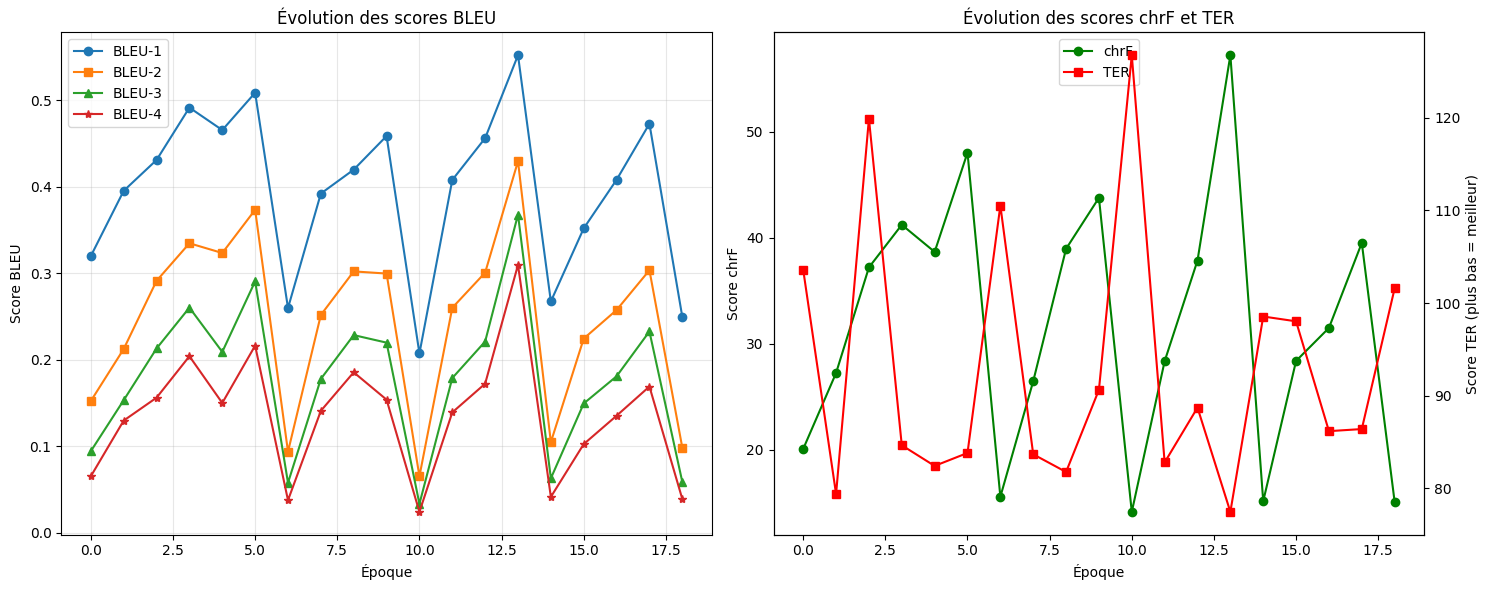

    Époque    BLEU-1    BLEU-2    BLEU-3    BLEU-4       chrF         TER
0        0  0.319800  0.152345  0.094420  0.065420  20.065624  103.590548
1        1  0.395153  0.212436  0.153276  0.129725  27.231457   79.404040
2        2  0.430751  0.291171  0.213023  0.156175  37.199657  119.900072
3        3  0.491250  0.334541  0.260213  0.204057  41.222448   84.662698
4        4  0.465291  0.323280  0.209050  0.150042  38.664191   82.436147
5        5  0.508435  0.373190  0.290585  0.216302  48.028417   83.832612
6        6  0.259727  0.093791  0.057837  0.037701  15.548202  110.523088
7        7  0.391967  0.251728  0.177857  0.140973  26.455454   83.689755
8        8  0.419567  0.302045  0.228460  0.185483  38.954449   81.781385
9        9  0.458417  0.299545  0.219745  0.153888  43.770642   90.646465
10      10  0.207289  0.065360  0.033503  0.024250  14.121449  126.749278
11      11  0.407673  0.260001  0.178853  0.139166  28.344299   82.813131
12      12  0.455967  0.300630  0.2210

Évaluation des têtes: 100%|██████████| 8/8 [02:07<00:00, 15.92s/it]


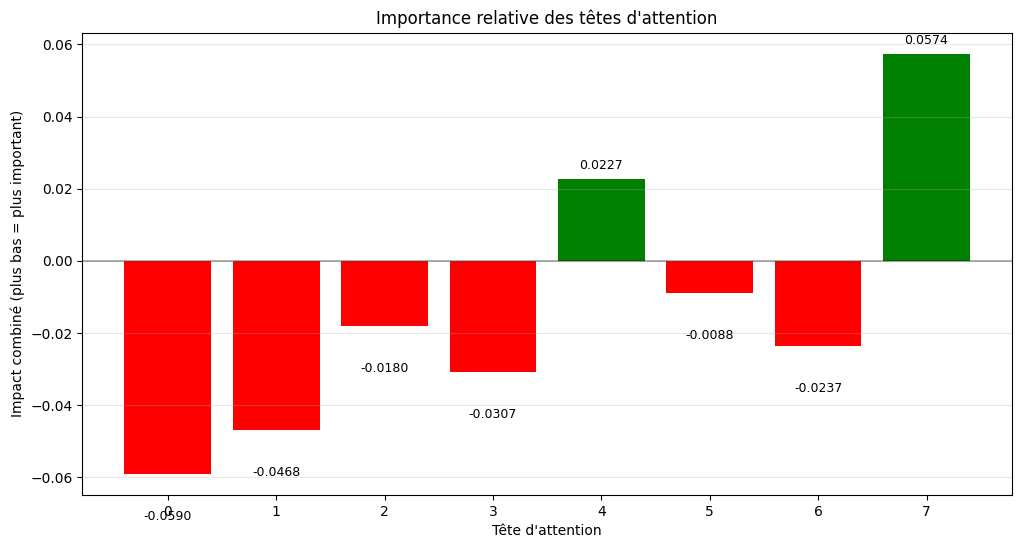

     Tête   BLEU-4 (impact)  chrF (impact)     TER (impact) Impact combiné
0  Tête 0  0.0289 (-0.0199)  13.08 (-2.85)  123.45 (+12.86)        -0.0590
1  Tête 1  0.0300 (-0.0189)  14.26 (-1.67)  121.07 (+10.48)        -0.0468
2  Tête 3  0.0362 (-0.0127)  14.88 (-1.05)   117.50 (+6.90)        -0.0307
3  Tête 6  0.0336 (-0.0153)  12.14 (-3.79)   112.38 (+1.79)        -0.0237
4  Tête 2  0.0325 (-0.0163)  14.29 (-1.64)   112.74 (+2.14)        -0.0180
5  Tête 5  0.0331 (-0.0157)  13.43 (-2.50)   109.17 (-1.43)        -0.0088
6  Tête 4  0.0429 (-0.0059)  15.24 (-0.69)   102.50 (-8.10)        +0.0227
7  Tête 7  0.0840 (+0.0352)  15.71 (-0.22)   96.67 (-13.93)        +0.0574

3. Recherche des combinaisons optimales de têtes...
Évaluation de référence avec toutes les têtes...
Scores de référence: BLEU-4=0.0488, chrF=15.93, TER=110.60

Évaluation des combinaisons avec 1 têtes...


Combinaisons de 1 têtes: 100%|██████████| 8/8 [05:11<00:00, 38.93s/it]



Évaluation des combinaisons avec 2 têtes...


Combinaisons de 2 têtes:   0%|          | 0/10 [00:02<?, ?it/s]


IndexError: too many indices for tensor of dimension 1

In [22]:
# In[16]: Exécution des analyses
# Choisir la dernière époque pour l'analyse
last_epoch = available_epochs[-1]
print(f"Utilisation de l'époque {last_epoch} pour l'analyse des têtes d'attention")

# Décommenter les lignes suivantes pour exécuter l'analyse complète
# Note: ces analyses peuvent prendre beaucoup de temps

# Évaluation des performances par époque
print("\n1. Évaluation des performances par époque...")
epoch_results = evaluate_epochs(test_set)
epoch_metrics_df = plot_epoch_results(epoch_results)
print(epoch_metrics_df)

# Évaluation de l'importance des têtes d'attention
print("\n2. Évaluation de l'importance des têtes d'attention...")
head_results = evaluate_attention_heads(test_set[:5], last_epoch)  # Utiliser un sous-ensemble pour accélérer
head_importance_df = plot_head_importance(head_results)
print(head_importance_df)

# Recherche des combinaisons optimales
print("\n3. Recherche des combinaisons optimales de têtes...")
combo_results = find_optimal_head_combinations(test_set[:5], last_epoch, max_heads_to_use=3)
combo_df = plot_best_combinations(combo_results)
print(combo_df)

# Analyse des patterns d'attention
print("\n4. Analyse des patterns d'attention des têtes importantes...")
# Supposons que les têtes 0, 2 et 5 sont importantes d'après les analyses précédentes
important_heads = [0, 2, 5]  # À remplacer par les têtes identifiées comme importantes
patterns = analyze_head_patterns(test_set[0]['src'], last_epoch, important_heads)